In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import xarray as xr
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


# 例子：社会关系地位与幸福感的关系

实例的数据来自 Many Labs 2 项目（osf.io/uazdm/）中的一个研究。
该研究探究了社会关系地位对于幸福感的影响 “Sociometric status and well-being”，
(Anderson, Kraus, Galinsky, & Keltner, 2012)。
该实验共采集了 6905 个样本。

In [2]:
# 导入数据
SMS_data = pd.read_csv('pan/SMS_Well_being.csv')[['uID','variable','factor','Country']]

In [3]:
# 把数据分为高低两种社会关系的地位的子数据以便画图与后续分析
plot_data = [
    sorted(SMS_data.query('factor=="Low"').variable[0:3000]),
    sorted(SMS_data.query('factor=="High"').variable[0:3000])]

## 通过画图对于两种社会关系地位对幸福感的影响

图中横坐标代表高低两种社会关系地位，纵坐标代表了主观幸福感评分。

In [4]:
# import matplotlib
# a = sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# for i in a:
#    print(i)

# 字体样式
font = {'family' : 'Source Han Sans CN'}
# 具体使用
plt.rc('font',**font)

In [5]:
# 画图对比两种社会地位对幸福感的影响
def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value

def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('社会关系地位')

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 4), sharey=True)

parts = ax1.violinplot(
        plot_data, showmeans=False, showmedians=False,
        showextrema=False)

for pc in parts['bodies']:
    pc.set_facecolor('#D43F3A')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

quartile1, medians, quartile3 = np.percentile(plot_data, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(plot_data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax1.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax1.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax1.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# set style for the axes
labels = ['低','高']
plt.xticks(np.arange(2)+1, labels)
plt.xlabel('社会关系地位')
plt.ylabel('幸福感')

plt.subplots_adjust(bottom=0.15, wspace=0.05)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


<Figure size 900x400 with 1 Axes>

### 通过t检验，分析两种社会关系地位下幸福感的差异

结果发现，两种社会关系水平下被试的主观幸福感边缘显著，t(6903) = -1.76, p = .08。

In [6]:
from scipy import stats
SMS_low = SMS_data.query('factor=="Low"').variable.values
SMS_high = SMS_data.query('factor=="High"').variable.values
print(
    f"低社会关系：{np.around(np.mean(SMS_low),3)} ± {np.around(np.std(SMS_low),2)}；",
    f"高社会关系：{np.around(np.mean(SMS_high),3)} ± {np.around(np.std(SMS_high),2)}")
stats.ttest_ind(
    a= SMS_low,
    b= SMS_high, 
    equal_var=True)

低社会关系：0.014 ± 0.66； 高社会关系：-0.014 ± 0.67


Ttest_indResult(statistic=1.7593310889762195, pvalue=0.07856558333862036)

## 通过模型思维替代t检验

相比于通过t检验分析不同社会关系地位下幸福感的差异，我们可以通过模型思维来解决这个问题。

首先，通过建立线性模型去替代原本的t检验模型。

其次，通过贝叶斯方法与pymc对线性模型建模与分析。

最后，展示了模型分析结果的丰富性。

In [8]:
# 通过pymc建立基于贝叶斯的线性模型
x = pd.factorize(SMS_data.factor)[0] # high为0，low为1
# coords = {
#     "obs": np.arange(SMS_data.shape[0]),
# }
with pm.Model() as linear_regression:
    sigma = pm.HalfCauchy("sigma", beta=2)
    β0 = pm.Normal("β0", 0, sigma=5)
    β1 = pm.Normal("β1", 0, sigma=5)
    x = pm.Data("x", x)
    # μ = pm.Deterministic("μ", β0 + β1 * x)
    pm.Normal("y", mu=β0 + β1 * x, sigma=sigma, observed=SMS_data.variable)

可以通过pymc自带的可视化工具将模型关系可视化。

x 为自变量，其中1为低社会关系，0为高社会关系。

参数 $\beta0$ 是线性模型的截距，而 $\beta1$ 是斜率。

截距代表了高社会关系地位被试的幸福感；而截距加上斜率表示低社会关系地位被试的幸福感。

参数$sigma$是残差，因变量$y$即主观幸福感。

模型图展示了各参数通过怎样的关系影响到因变量。

In [9]:
pm.model_to_graphviz(linear_regression)

In [10]:
# 模型拟合过程 (mcmc采样过程)
with linear_regression:
    idata = pm.sample(2000, tune=1000, target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [β1, β0, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 22 seconds.


### 参数的后验分布
这里的模型分析结果展示了各参数的分布(后验)情况

In [11]:
az.plot_trace(idata);

<Figure size 1200x600 with 6 Axes>

下图反应了参数β1的可信度，即两个社会关系下幸福感差异的可信度。

结果显示，两个社会关系下幸福感差异的可信度为96%。

In [12]:
(idata.posterior.β1 > 0).mean().values

array(0.9625)

In [13]:
az.plot_posterior(idata, var_names=['β1'], kind='hist',ref_val=0)

<AxesSubplot:title={'center':'β1'}>

<Figure size 720x480 with 1 Axes>

### 模型检验

通过模型思维进行数据分析需要注意模型检验，即检验模型是否能有效的反应数据的特征。

下表格为模型参数的基本信息：

mean和sd 为各参数的均值和标准差；
hdi 3%-97% 为参数分布的可信区间；
msce mean和sd 为mcmc采样标准误统计量的均值和标准差；
ess bulk和tail 反应了mcmc采样有效样本数量相关性能；
r hat 为参数收敛性的指标。

In [14]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,-0.014,0.011,-0.036,0.007,0.0,0.0,3962.0,4670.0,1.0
β1,0.028,0.016,-0.002,0.057,0.0,0.0,4070.0,4838.0,1.0
sigma,0.661,0.006,0.649,0.671,0.0,0.0,4591.0,4710.0,1.0


### 后验预测检验 ppc (posterior predictive check)

In [89]:
with linear_regression:
    pm.set_data({"x": np.array([0,1])})
    ppc_y = pm.sample_posterior_predictive(idata, var_names=["y"],keep_size=True)["y"] # keep size不是data的size 而是mcmc的size

In [103]:
labels = ['低', '高']
obs_low = SMS_data.query('factor=="Low"').variable
obs_high = SMS_data.query('factor=="High"').variable
ppc_y2 = [j for i in ppc_y for j in i]
ppc_low = [i[1] for i in ppc_y2]
ppc_high = [i[0] for i in ppc_y2]
# reg_post = idata.posterior.stack(chain_draw=("chain", "draw"))
# ppc_x = np.repeat([0,1],len(reg_post.sigma)/2)
# ppc_y = reg_post['β0'] + reg_post['β1']*ppc_x
# ppc_low = ppc_y[ppc_x==1].values
# ppc_high = ppc_y[ppc_x==0].values

fig, ax = plt.subplots()
part1 = ax.violinplot(
    [list(obs_low),list(obs_high)], 
    [1,4], points=100, widths=0.3, 
    showmeans=True, showextrema=True, showmedians=True)
part2 = ax.violinplot(
    [list(ppc_low),list(ppc_high)], 
    [2,5], points=100, widths=0.3, 
    showmeans=True, showextrema=True, showmedians=True)
part1['bodies'][0].set_label('观测数据')
part2['bodies'][0].set_label('预测数据')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('幸福感')
ax.set_title('Posterior predictive check')
plt.xticks([1.5,4.5], labels)
ax.legend()

fig.tight_layout()
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


<Figure size 720x480 with 1 Axes>

# 模型思维对于认知机制的意义

在实验数据的收集时，研究者往往会采集个体反应的正确率与反应时。

而传统分析方法并不能同时对两种数据进行分析，从而推断潜在的认知机制。比如，个体是否愿意牺牲更多的反应时间去获得一个更准确的判断。

认知模型能有效的弥补这一问题，比如 drift-diffusion model, DDM。


![DDM1](https://cdn.kesci.com/upload/image/rhb2957an5.png?imageView2/0/w/960/h/960)


该模型假设，被试的判断需要收集的实验刺激的信息，进而做出正确或错误的判断。

信息累积的过程就是漂移过程，用参数v表示。

而信息累积的方向，即上下两个边界，代表被试的判断是否正确，用a表示。

其他影响决策的参数包括，非决策反应用时与决策前的判断偏差。

可见，**使用认知模型可以同时结合反应时与判断的正确性，并推断出更多的认知机制**。

In [1]:
import hddm
hddm.__version__

HDDM: pytorch module seems missing. No LAN functionality can be loaded.
It seems that you do not have pytorch installed. You cannot use the network_inspector module.
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor and HDDMnnStimCodingclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRL, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work
It seems that you do not have pytorch installed.The HDDMnn, HDDMnnRegressor, HDDMnnStimCoding, HDDMnnRL and HDDMnnRLRegressorclasses will not work


'0.9.7'

模型图示

模型拟合

In [7]:
data = hddm.load_csv("simple_difficulty.csv")

# Create a HDDM model multi object
model = hddm.HDDM(data, depends_on={"v": "difficulty"})

# Create model and start MCMC sampling
model.sample(5000, burn=2000)


No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 5000 of 5000 complete in 99.4 sec

模型分析结果

In [8]:
# Print fitted parameters and other model statistics
model.print_stats()

             mean       std      2.5q       25q       50q       75q     97.5q    mc err
a        1.964337  0.039208  1.889998    1.9372  1.963819  1.990955  2.041962  0.001106
v(easy)  1.086277  0.060862  0.970537  1.045353  1.086023  1.127076   1.20418   0.00118
v(hard)  0.583316  0.052764  0.485529  0.546442  0.583558   0.61898  0.687896   0.00092
t        0.311001  0.009292  0.293203   0.30463  0.310802  0.317445  0.329226  0.000262
DIC: 2326.732003
deviance: 2322.553798
pD: 4.178205


Plotting a
Plotting v(easy)
Plotting v(hard)
Plotting t


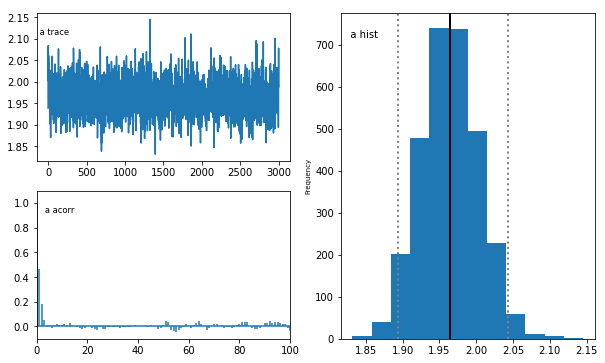

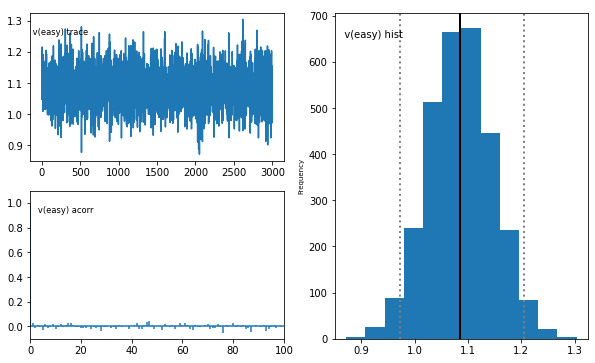

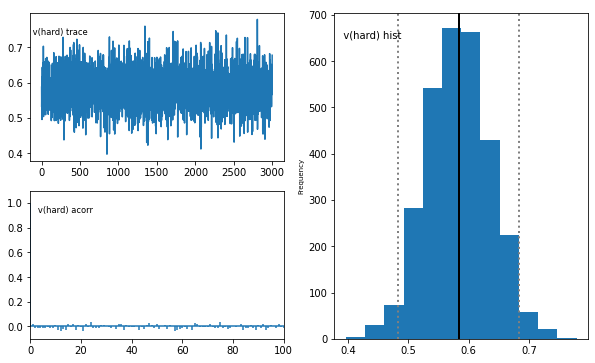

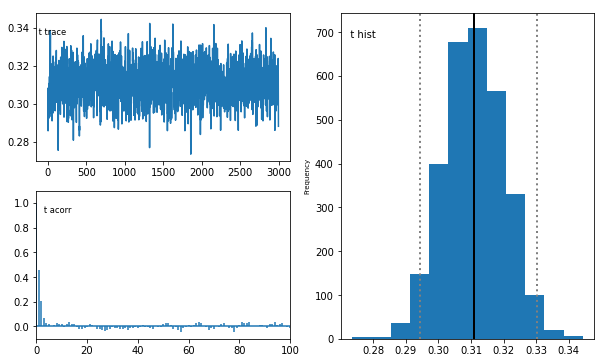

In [9]:
# Plot posterior distributions and theoretical RT distributions
model.plot_posteriors()

d:\Miniconda3\envs\hddm39\lib\site-packages\kabuki-0.6.5-py3.9.egg\kabuki\analyze.py:589: UserWarning: Too many nodes. Consider increasing number of columns.


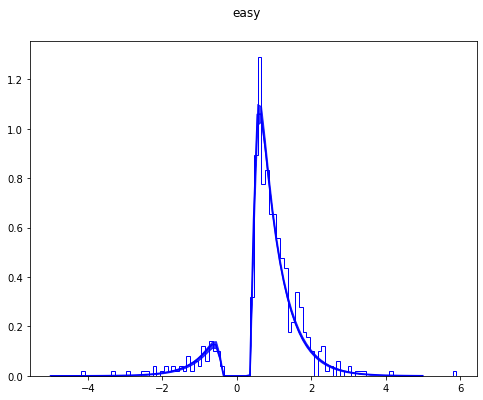

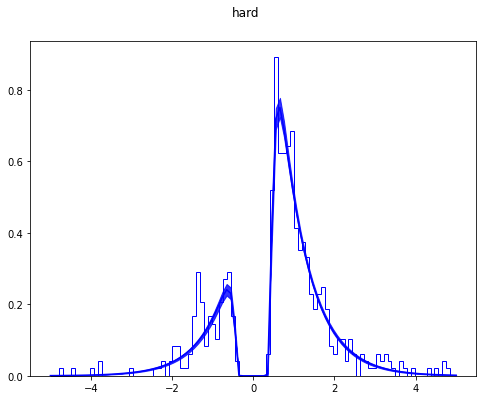

In [10]:
model.plot_posterior_predictive()